In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os, contextlib
import cv2
import numpy as np
import random
import shutil
import sys
from PIL import Image
import datetime as dt

import tensorflow as tf
import tensorboard

import scipy

import keras
import keras.backend as K
from keras.layers import Dense, Flatten, Conv2D, GlobalAveragePooling2D
from keras import Model
from keras.applications import vgg16
from keras.preprocessing import image as image_utils

import matplotlib.pyplot as plt

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import innvestigate

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1366210439219490932
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7064984082178381600
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Import Pretrained VGG16

In [3]:
#Take pretrained model
base_model = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

In [9]:
#finetuning model setup (might want to take those 2 fc's.. this is a lot of params)

K.set_learning_phase(0)

base_model = vgg16.VGG16(weights='imagenet', include_top=True, pooling = None, classes=1000, input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-2].output
#flattened = Flatten(name='flatten')(x)
#fc1 = Dense(4096, name='fc1', activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))(flattened) 
#fc2 = Dense(4096, name='fc2', activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))(fc1) 
predictions = Dense(100, name='predictions', activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))(x) 
model2 = Model(inputs=base_model.input, outputs=predictions)
mpool = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

K.set_learning_phase(1)

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Quick ImageNet Check

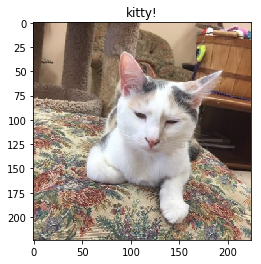

In [10]:
image = image_utils.load_img("./data/kitty.jpg",target_size=(224, 224))
plt.imshow(image)
plt.title('kitty!')
x = image_utils.img_to_array(image)
x = np.expand_dims(x,0)
x = vgg16.preprocess_input(x)

In [11]:
preds = base_model.predict(x)
decoded_preds = vgg16.decode_predictions(preds)
print('Predicted:', decoded_preds)

Predicted: [[('n02124075', 'Egyptian_cat', 0.71457726), ('n02123045', 'tabby', 0.08797774), ('n02123159', 'tiger_cat', 0.03745288), ('n02123597', 'Siamese_cat', 0.03613024), ('n02110185', 'Siberian_husky', 0.033777695)]]


## IMDB-WIKI Dataset

Text(0.5, 1.0, 'human.')

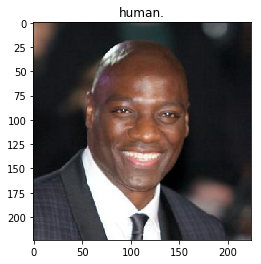

In [12]:
# grab images from database
image = image_utils.load_img('Z:/wiki_crop/00/2452600_1967-08-22_2013.jpg', target_size=(224,224))
plt.imshow(image)
plt.title("human.")
x = image_utils.img_to_array(image)
x = np.expand_dims(x,0)
x = vgg16.preprocess_input(x)

In [13]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, 
    samplewise_center=False, 
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False, 
    zca_whitening=False, 
    zca_epsilon=1e-06, 
    rotation_range=0, 
    width_shift_range=0.0, 
    height_shift_range=0.0, 
    brightness_range=None, 
    shear_range=0.0, 
    zoom_range=0.0, 
    channel_shift_range=0.0, 
    fill_mode='nearest', 
    cval=0.0, 
    horizontal_flip=False, 
    vertical_flip=False, 
    rescale=None, 
    preprocessing_function=vgg16.preprocess_input, 
    data_format=None, 
    validation_split=0.2, 
    dtype=None)

In [19]:
BS = 128

train_it = datagen.flow_from_directory('Z:/wiki_crop/', class_mode = 'categorical', batch_size=BS, target_size=(224,224), shuffle=True, subset='training', seed=1337)
val_it = datagen.flow_from_directory('Z:/wiki_crop/', class_mode='categorical', batch_size=BS, target_size=(224,224), shuffle=False, subset='validation')

Found 49902 images belonging to 100 classes.
Found 12426 images belonging to 100 classes.


## Model Retraining

In [20]:
#callbacks to use during trinaing
cpcb = keras.callbacks.ModelCheckpoint(
    './checkpoints_vgg16/weights.{}.hdf5'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"-catxeloss-catacc-lr01-m09_sgd-LPHASE"), 
    monitor='val_categorical_accuracy', verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='auto', 
    period=5)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)

In [23]:
#choice of optimizer
mx_opt = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0, nesterov=True)
model2.compile(optimizer = mx_opt, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

In [ ]:
#training (note:only using a quarter of samples for now)
history = model2.fit_generator(
    train_it,
    steps_per_epoch = train_it.samples*0.25 // BS,
    validation_data = val_it, 
    validation_steps = val_it.samples*0.25 // BS,
    epochs = 15,
    callbacks = [ reduce_lr, cpcb ])

Epoch 1/15
55/97 [================>.............] - ETA: 4:08 - loss: 18.5481 - categorical_accuracy: 0.0102

## Relevance Analysis

In [ ]:
# define model analyser
analyzer = innvestigate.create_analyzer("lrp", model2)

In [ ]:
# grab image from database
image = image_utils.load_img('Z:/wiki_crop/00/2452600_1967-08-22_2013.jpg', target_size=(224,224))
plt.imshow(image)
plt.title("human.")
x = image_utils.img_to_array(image)
x = np.expand_dims(x,0)
x = vgg16.preprocess_input(x)

In [ ]:
a = analyzer.analyze(x)